In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.max_columns = 100

# EDA and Data Cleaning


In [ ]:
df = pd.read_csv("../data/transfers.csv")

In [100]:
df.head()

,league,season,window,team_id,team_name,team_country,player_id,player_name,player_age,player_nation,player_nation2,player_pos,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,8198,Cristiano Ronaldo,24.0,Portugal,NaN,CF,418,Real Madrid,Spain,94000000.0,45000000.0,False,False,False,False,308498
1,GB1,2009,s,985,Manchester United,England,42411,Fraizer Campbell,21.0,England,Jamaica,CF,289,Sunderland AFC,England,4100000.0,700000.0,False,False,False,False,316117
2,GB1,2009,s,985,Manchester United,England,64484,Manucho,26.0,Angola,Portugal,CF,366,Real Valladolid CF,Spain,2750000.0,NaN,False,False,False,False,320029
3,GB1,2009,s,985,Manchester United,England,15449,Lee Martin,22.0,England,NaN,AM,677,Ipswich Town,England,2250000.0,250000.0,False,False,False,False,314073
4,GB1,2009,s,985,Manchester United,England,34130,Tom Heaton,23.0,England,NaN,GK,1039,Queens Park Rangers,England,NaN,1000000.0,False,True,False,False,333026


## NA Values


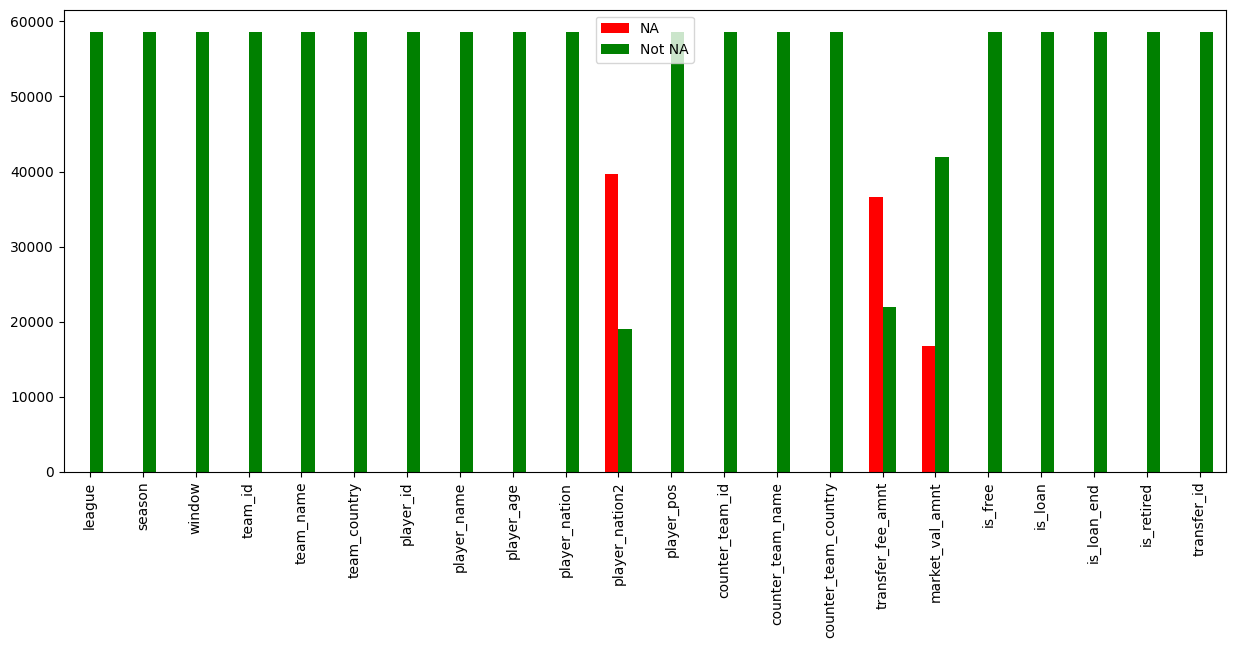

In [ ]:
na_counts = df.isna().sum()
not_na_counts = df.notna().sum()
plot_df = pd.DataFrame({"NA": na_counts, "Not NA": not_na_counts}).plot(
    kind="bar", figsize=(15, 6), color=["red", "green"]
)

<Axes: xlabel='is_loan'>

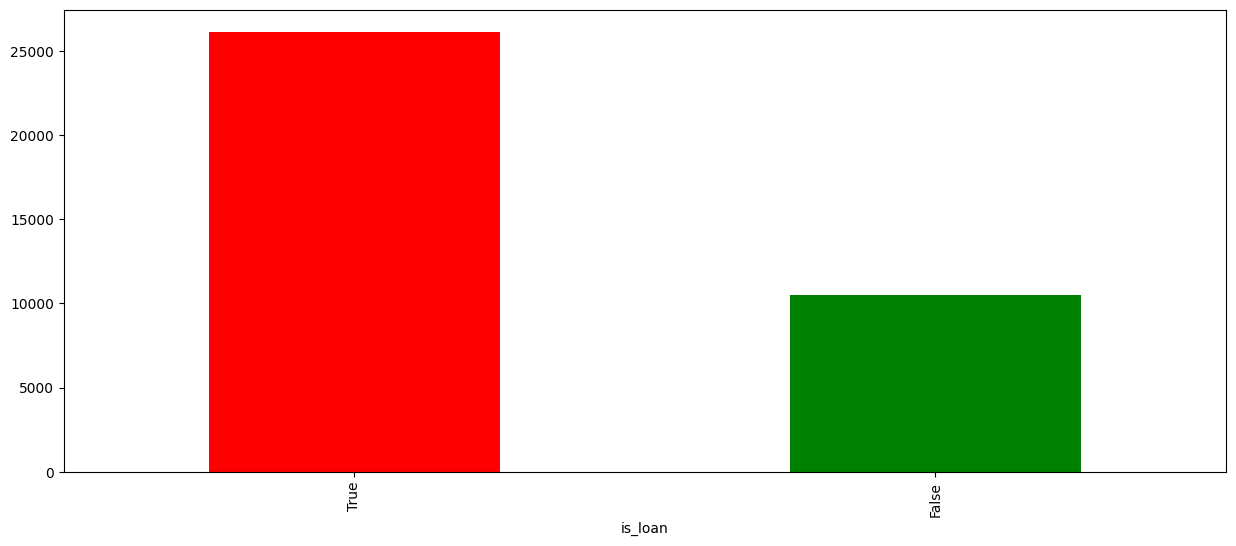

In [112]:
df[df["transfer_fee_amnt"].isna()]["is_loan"].value_counts().plot(
    kind="bar", figsize=(15, 6), color=["red", "green"]
)

In [ ]:
df[df["is_loan"] == True]["transfer_fee_amnt"].value_counts(ascending=True)

transfer_fee_amnt
24000.0         1
3800000.0       1
92000.0         1
5500000.0       1
13000000.0      1
             ... 
300000.0      100
100000.0      121
200000.0      135
1000000.0     165
500000.0      222
Name: count, Length: 177, dtype: int64

In [ ]:
# Count number of na in column transfer_fee_ambt per season
df.groupby(["season"])["transfer_fee_amnt"].apply(lambda x: x.isna().sum()).reset_index(
    name="na_count"
).sort_values(by="na_count", ascending=False)

,season,na_count
5,2014,3155
4,2013,3046
10,2019,2948
6,2015,2901
11,2020,2859
8,2017,2844
9,2018,2829
1,2010,2823
3,2012,2817
7,2016,2800


It seems that the NA values for the transfer_fee_amnt are mainly for loans


## Removing duplicates


In [ ]:
df[df["transfer_id"] == 308498]

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,player_nation,player_nation2,player_pos,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
12,GB1,2009,s,985,Manchester United,England,left,8198,Cristiano Ronaldo,24.0,Portugal,NaN,CF,418,Real Madrid,Spain,94000000.0,45000000.0,False,False,False,False,308498
11443,ES1,2009,s,418,Real Madrid,Spain,in,8198,Cristiano Ronaldo,24.0,Portugal,NaN,CF,985,Manchester United,England,94000000.0,45000000.0,False,False,False,False,308498


In [ ]:
transfer_id_count = df.groupby("transfer_id").size()
transfer_id_count

transfer_id
68451      1
86251      1
114133     1
128446     1
128615     1
          ..
3630750    1
3632046    1
3632617    1
3632931    1
3633188    1
Length: 58640, dtype: int64

Some transfers are twice in the dataset, one as a in-transfert and another as a out-transfer. We need to remove one of them.


<Axes: xlabel='dir'>

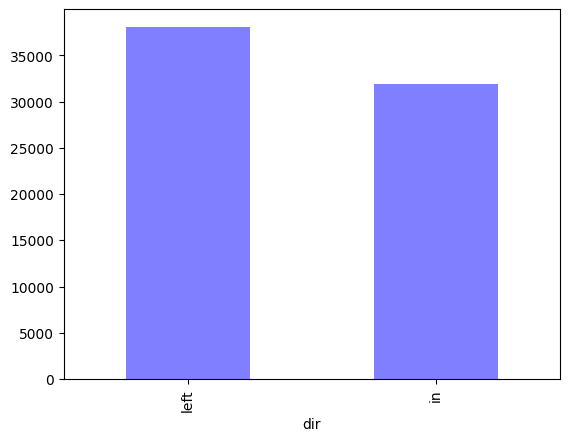

In [ ]:
df["dir"].value_counts().plot(kind="bar", color="blue", alpha=0.5)

In [ ]:
to_drop = transfer_id_count[transfer_id_count > 1].index
df_in = df[df["dir"] == "in"]
to_drop = df_in[df_in["transfer_id"].isin(to_drop)].index
df = df.drop(to_drop)

<Axes: xlabel='dir'>

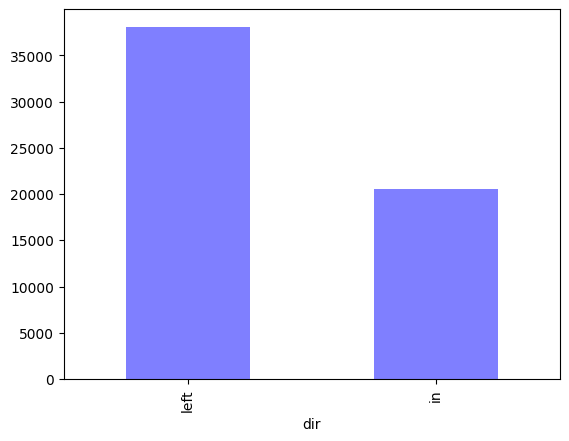

In [ ]:
df["dir"].value_counts().plot(kind="bar", color="blue", alpha=0.5)

## Swap to the order of the transfer to only have 'dir' == 'left'


In [83]:
df_in.head(5)

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,player_nation,player_nation2,player_pos,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,Senegal,NaN,CF,687,Molde FK,Norway,4500000.0,1600000.0,False,False,False,False,319841
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,England,NaN,CF,762,Newcastle United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,England,NaN,CB,5242,Manchester United U18,England,NaN,NaN,False,False,False,False,339015
6,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,England,NaN,CB,2962,Altrincham FC,England,NaN,NaN,False,True,True,False,351895
7,GB1,2009,s,985,Manchester United,England,in,73482,James Chester,20.0,Wales,England,CB,2262,Plymouth Argyle,England,NaN,1200000.0,False,True,True,False,373518


In [ ]:
df_out = df[df["dir"] == "left"]
df_in = df[df["dir"] == "in"]

swap_map = {
    "team_id": "counter_team_id",
    "team_name": "counter_team_name",
    "team_country": "counter_team_country",
}
swap_map.update({v: k for k, v in swap_map.items()})
df_in = df_in.rename(columns=swap_map)
df_in = df_in[df_out.columns]  # Keep the same col order

In [90]:
df_in.head(5)

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,player_nation,player_nation2,player_pos,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
1,GB1,2009,s,687,Molde FK,Norway,in,62049,Mame Diouf,21.0,Senegal,NaN,CF,985,Manchester United,England,4500000.0,1600000.0,False,False,False,False,319841
3,GB1,2009,s,762,Newcastle United,England,in,1397,Michael Owen,29.0,England,NaN,CF,985,Manchester United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,5242,Manchester United U18,England,in,73538,Scott Moffatt,18.0,England,NaN,CB,985,Manchester United,England,NaN,NaN,False,False,False,False,339015
6,GB1,2009,s,2962,Altrincham FC,England,in,73538,Scott Moffatt,18.0,England,NaN,CB,985,Manchester United,England,NaN,NaN,False,True,True,False,351895
7,GB1,2009,s,2262,Plymouth Argyle,England,in,73482,James Chester,20.0,Wales,England,CB,985,Manchester United,England,NaN,1200000.0,False,True,True,False,373518


In [ ]:
df = pd.concat([df_out, df_in], ignore_index=True).drop(columns=["dir"])
df

,league,season,window,team_id,team_name,team_country,player_id,player_name,player_age,player_nation,player_nation2,player_pos,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,8198,Cristiano Ronaldo,24.0,Portugal,NaN,CF,418,Real Madrid,Spain,94000000.0,45000000.0,False,False,False,False,308498
1,GB1,2009,s,985,Manchester United,England,42411,Fraizer Campbell,21.0,England,Jamaica,CF,289,Sunderland AFC,England,4100000.0,700000.0,False,False,False,False,316117
2,GB1,2009,s,985,Manchester United,England,64484,Manucho,26.0,Angola,Portugal,CF,366,Real Valladolid CF,Spain,2750000.0,NaN,False,False,False,False,320029
3,GB1,2009,s,985,Manchester United,England,15449,Lee Martin,22.0,England,NaN,AM,677,Ipswich Town,England,2250000.0,250000.0,False,False,False,False,314073
4,GB1,2009,s,985,Manchester United,England,34130,Tom Heaton,23.0,England,NaN,GK,1039,Queens Park Rangers,England,NaN,1000000.0,False,True,False,False,333026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58635,NL1,2021,s,7006,Melbourne Victory,Australia,480022,Dylan Ryan,21.0,Australia,NaN,CB,403,Willem II Tilburg,Netherlands,NaN,125000.0,False,True,True,False,3136068
58636,NL1,2021,w,515,Without Club,Without Club,140032,Andreas Samaris,32.0,Greece,NaN,DM,385,Fortuna Sittard,Netherlands,NaN,1500000.0,False,False,False,False,3633188
58637,NL1,2021,w,1293,Tromsø IL,Norway,257808,Runar Espejord,25.0,Norway,NaN,CF,306,SC Heerenveen,Netherlands,NaN,500000.0,False,True,True,False,3071862
58638,NL1,2021,w,37535,Montevideo City Torque,Uruguay,580142,Joaquín Fernández,22.0,Uruguay,Italy,CB,306,SC Heerenveen,Netherlands,NaN,100000.0,False,True,True,False,3268245


## Jsp


In [ ]:
df[
    ((df["team_name"] == "FC Nantes") | (df["counter_team_name"] == "FC Nantes"))
    & (df["season"] == 2010)
]

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,player_nation,player_nation2,player_pos,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
1299,GB1,2010,s,355,Bolton Wanderers,England,in,690,Ivan Klasnic,30.0,Croatia,NaN,CF,995,FC Nantes,France,0.0,NaN,True,False,False,False,458999
1322,GB1,2010,s,355,Bolton Wanderers,England,left,690,Ivan Klasnic,30.0,Croatia,NaN,CF,995,FC Nantes,France,NaN,NaN,False,True,True,False,338866
43754,FR1,2010,s,1423,Valenciennes FC,France,left,53306,Guy Ndy Assembé,24.0,Cameroon,France,GK,995,FC Nantes,France,NaN,100000.0,False,True,True,False,331153
43781,FR1,2010,s,826,RC Lens,France,in,64992,Issam El Adoua,23.0,Morocco,NaN,DM,995,FC Nantes,France,NaN,200000.0,False,True,True,False,379255
43831,FR1,2010,s,162,AS Monaco,France,in,39911,Massamba Sambou,23.0,Senegal,NaN,CB,995,FC Nantes,France,NaN,150000.0,False,True,True,False,329879
43850,FR1,2010,s,162,AS Monaco,France,left,40064,Frédéric Nimani,21.0,Central African Republic,France,CF,995,FC Nantes,France,NaN,200000.0,False,True,False,False,473677
43930,FR1,2010,s,290,AJ Auxerre,France,left,18299,Aurélien Capoue,28.0,Guadeloupe,France,LW,995,FC Nantes,France,NaN,NaN,False,True,True,False,338292
43983,FR1,2010,s,618,AS Saint-Étienne,France,in,12515,Guirane N'Daw,26.0,Senegal,France,DM,995,FC Nantes,France,3000000.0,NaN,False,False,False,False,417773
44006,FR1,2010,s,618,AS Saint-Étienne,France,left,12515,Guirane N'Daw,26.0,Senegal,France,DM,995,FC Nantes,France,NaN,NaN,False,True,True,False,323421
44143,FR1,2010,w,162,AS Monaco,France,left,36293,Serge Gakpé,23.0,Togo,France,RW,995,FC Nantes,France,0.0,300000.0,True,False,False,False,534371


There seem to be some particular rows in the dataset, some player appear twice during the same season but it is because of loans. Some loans are free and some are paid.


# Graph Modeling


We will model the dataset as one graph per season where

- Each club is a node and each transfer is an edge.
- The weight of the edge will be the amount of money paid for the transfer.
- We will add a direction to the edges, from the club that sells the player to the club that buys the player.
- We will add a property to the nodes that will be the number of players that have been transferred in and out of the club.
- We will also model loans as edges, but we will not add a weight to them.
- We will add a property to the edges that will be the type of transfer (loan or permanent).


In [28]:
seasons = df["season"].unique()
seasons

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021])

## Working on one season


In [ ]:
subset = df[df["season"] == 2021]

In [ ]:
def count_player_positions(group):
    """
    Count the number of players in each position for a given group.
    """
    return group["player_pos"].value_counts()

In [ ]:
df_club = (
    subset.groupby(["team_name", "counter_team_name"])
    .apply(count_player_positions)
    .reset_index()
)
df_club = df_club.pivot_table(
    index=["team_name", "counter_team_name"],
    columns="player_pos",
    values="count",
    fill_value=0,
    aggfunc="sum",
)
df_club = df_club.reset_index()
df_club

player_pos,team_name,counter_team_name,AM,CB,CF,CM,DM,GK,LB,LM,LW,RB,RM,RW,SS,midfield
0,1. FC Köln,1.FC Köln II,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1. FC Köln,1.FSV Mainz 05,0,2,0,0,0,0,0,0,0,0,0,0,0,0
2,1. FC Köln,AS Monaco,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1. FC Köln,AS Saint-Étienne,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1. FC Köln,Aarhus GF,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,Wolverhampton Wanderers,Sevilla FC,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3131,Wolverhampton Wanderers,Sheffield United,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3132,Wolverhampton Wanderers,Sporting CP,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3133,Wolverhampton Wanderers,St. Mirren FC,0,0,0,2,0,0,0,0,0,0,0,0,0,0
